In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sn

## Arima will only handle Univariate data, not multivariate

# 1. Loading the Data

In [2]:
# FRED Economic Dataset

df=pd.read_csv('/kaggle/input/time-series-part-1/IPG2211A2N.csv')

In [3]:
df.head()

,DATE,IPG2211A2N
0,1939-01-01,3.3336
1,1939-02-01,3.3591
2,1939-03-01,3.4354
3,1939-04-01,3.4608
4,1939-05-01,3.4608


In [4]:
df.shape

(1029, 2)

-------

# 2. Data Preprocessing 

In [10]:
df.isna().sum()

DATE          0
IPG2211A2N    0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        1029 non-null   object 
 1   IPG2211A2N  1029 non-null   float64
dtypes: float64(1), object(1)
memory usage: 16.2+ KB


## Converting the Date column into Datetime data type

In [12]:
df['DATE']=pd.to_datetime(df['DATE'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        1029 non-null   datetime64[ns]
 1   IPG2211A2N  1029 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 16.2 KB


## Using 'DATE' Column is our Index as dataset

In [14]:
df.set_index('DATE', inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1029 entries, 1939-01-01 to 2024-09-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IPG2211A2N  1029 non-null   float64
dtypes: float64(1)
memory usage: 16.1 KB


In [16]:
df.head()

,IPG2211A2N
DATE,
1939-01-01,3.3336
1939-02-01,3.3591
1939-03-01,3.4354
1939-04-01,3.4608
1939-05-01,3.4608


-----------

# 3. Checking Stationarity of Data

#### 1) When we are working with ARIMA Model, it is mandetory to check if our data is stationary or not.

#### 2) Stationary means data should oscillate around the mean of 0 and should have constant variance.

#### 3) If we find our data is in uptrend or downtrend, then it is not stationary.

#### 4) We can check the stationary of the data by visualizing and this is only possible when we set the date      column as index.

#### 5) Or we can check the stationary of the data, by performing ADF Test, where it will return a p-value and Depending upon the p-value, you will identify whether the data is stationary or not.

## i) First Condition of checking, whether the data is stationary or not.

<Axes: xlabel='DATE'>

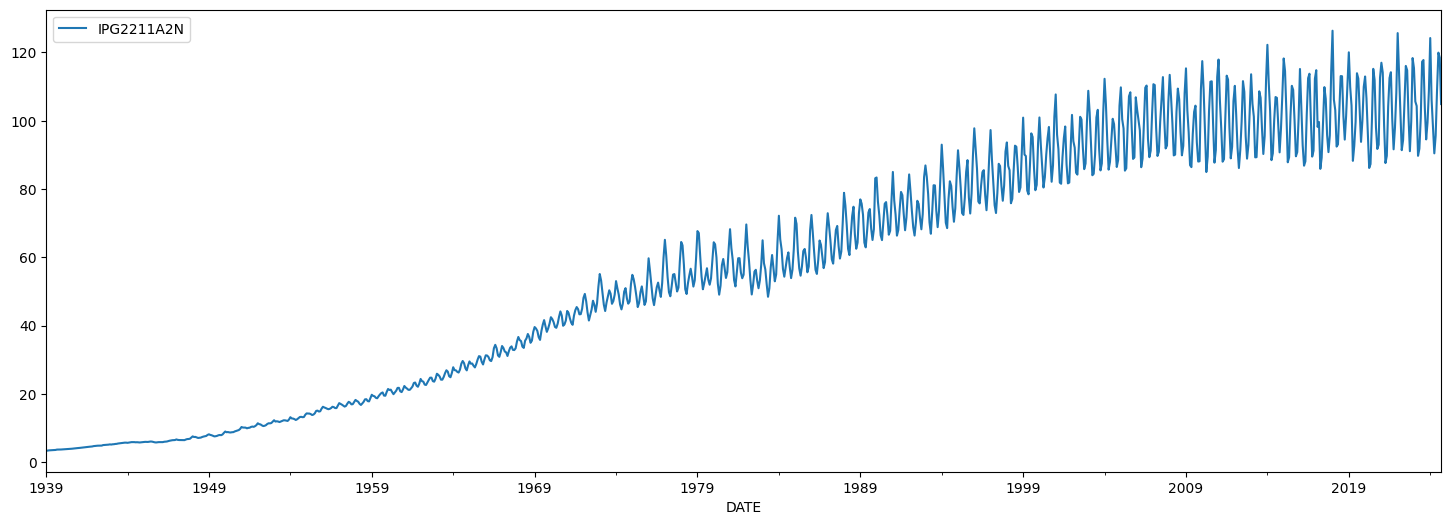

In [19]:
df.plot(figsize=(18,6))

1. **We are seeing the uptrend data.**
2. **Data is not stationary.**
3. **It is not oscillating around the mean of 0**
4. **Data is not constant.**

## ii) ADF Test --> Augmented Dickey Fuller test


#### It will return a p-value and Depending upon the p-value, you will identify whether the data is stationary or not.

In [20]:
from statsmodels.tsa.stattools import adfuller

In [25]:
def adf_test(data):

    result=adfuller(data)
    
    print(f'ADF Statistic : {result[0]}')
    print(f'p-value: {result[1]}')

    
    if result[1] <= 0.05:
        
        print("Reject the Null Hypothesis || Data is Stationary")
    
    else:
        
        print("Accept the Null Hypothesis || Data is not Stationary")

In [26]:
adf_test(df['IPG2211A2N'])

ADF Statistic : -0.7362987721608242
p-value: 0.8371220104401436
Accept the Null Hypothesis || Data is not Stationary


#### a) So our ARIMA Model cannot handle the non-stationary Data.

#### b) So it's mandetory to convert it into Stationary.

-------

# 4. Converting the data into Stationary

#### 1) We can use Differencing method here to perform stationarity.

#### 2) First we will perform 1st order diff, and if the data is not stationary, then we will perform 2nd diff and this process must be go on.

In [27]:
df['First_Order']=df['IPG2211A2N'].diff()

In [28]:
df.head()

,IPG2211A2N,First_Order
DATE,,
1939-01-01,3.3336,NaN
1939-02-01,3.3591,0.0255
1939-03-01,3.4354,0.0763
1939-04-01,3.4608,0.0254
1939-05-01,3.4608,0.0000


### Dropping the Null values

In [31]:
df.isna().sum()

IPG2211A2N     0
First_Order    1
dtype: int64

In [32]:
df.dropna(inplace=True)

In [33]:
df.isna().sum()

IPG2211A2N     0
First_Order    0
dtype: int64

#### So First Row has been deleted and we get our data cleaned.

In [34]:
df.head()

,IPG2211A2N,First_Order
DATE,,
1939-02-01,3.3591,0.0255
1939-03-01,3.4354,0.0763
1939-04-01,3.4608,0.0254
1939-05-01,3.4608,0.0000
1939-06-01,3.5117,0.0509


## a) Passing our 'First_Order' column to check whether it is Stationary or not.

In [35]:
adf_test(df['First_Order'])

ADF Statistic : -10.343364964299592
p-value: 2.6495525249857338e-18
Reject the Null Hypothesis || Data is Stationary


### b) Visualizing the 'First_Order'

<Axes: xlabel='DATE'>

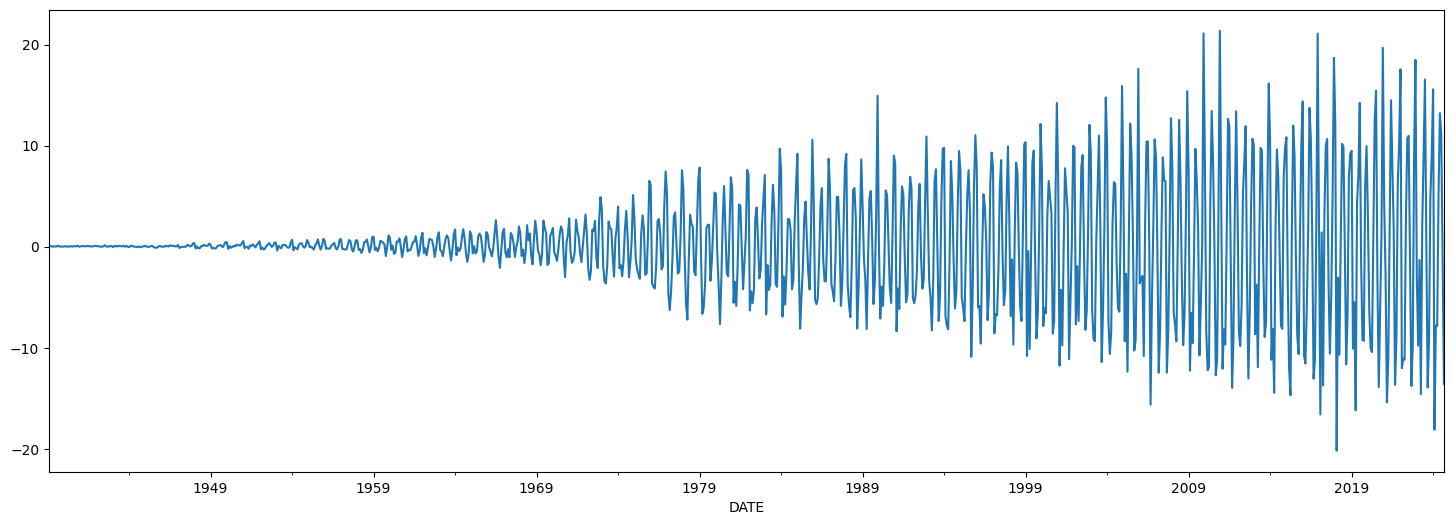

In [37]:
df['First_Order'].plot(figsize=(18,6))

1. **As you can see, the data is constant. There is no uptrend or down trend present here.**

2. **It is oscillating around the mean of 0 with constant variance.**

---------

# 5. Train Test Split

#### We are calculating manually the 80% of the data here, we will not be using train test split here.

In [39]:
0.8 * len(df)

822.4000000000001

In [40]:
train=df[['First_Order']][:822]

test=df[['First_Order']][822:]


In [41]:
train.shape, test.shape

((822, 1), (206, 1))

----------

# 6. Determining the ARIMA Parameters, --> p,d,q

1. **p: The number of lag observations, also known as the lag order.**
2. **d: The number of times the raw observations are differenced, also known as the degree of differencing.**
3. **q: The size of the moving average window, also known as the order of the moving average.**

#### We will be not plotting acf and pacf by manually, but it is not giving the excact or proper output.

#### So we will use AutoARIMA for better parameters.It is inbuilt method.

#### AutoARIMA takes train data and returns the output.

In [43]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.6 MB/s eta 0:00:0000:010:01


In [44]:
from pmdarima import auto_arima

### Arima model cannot handle seasonal data, we have to use SARIMA for seasonal data.

In [45]:
autoArima=auto_arima(train, seasonal= False)

In [47]:
print(autoArima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  822
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1754.822
Date:                Mon, 21 Oct 2024   AIC                           3521.645
Time:                        07:25:49   BIC                           3549.915
Sample:                    02-01-1939   HQIC                          3532.491
                         - 07-01-2007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1014      0.068      1.488      0.137      -0.032       0.235
ar.L1          0.9998      0.001    906.240      0.000       0.998       1.002
ar.L2         -0.9995      0.001  -1299.535      0.0

It is p,d,q value --> SARIMAX(2, 0, 2)

In [48]:
autoArima.order

(2, 0, 2)

---------

# 7. Building the ARIMA Model

In [49]:
from statsmodels.tsa.arima.model import ARIMA

In [50]:
model=ARIMA(train, order=autoArima.order)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


---------

# 8. Forcasting Data

In [51]:
forecast=autoArima.predict(n_periods=len(test))

# We are performing the step cause, our forecast is only based on test data of 206 rows. so that's why we use this step.
df['forecast']=[None]* len(train) + list(forecast)

In [52]:
df.head()

,IPG2211A2N,First_Order,forecast
DATE,,,
1939-02-01,3.3591,0.0255,NaN
1939-03-01,3.4354,0.0763,NaN
1939-04-01,3.4608,0.0254,NaN
1939-05-01,3.4608,0.0000,NaN
1939-06-01,3.5117,0.0509,NaN


<Axes: xlabel='DATE'>

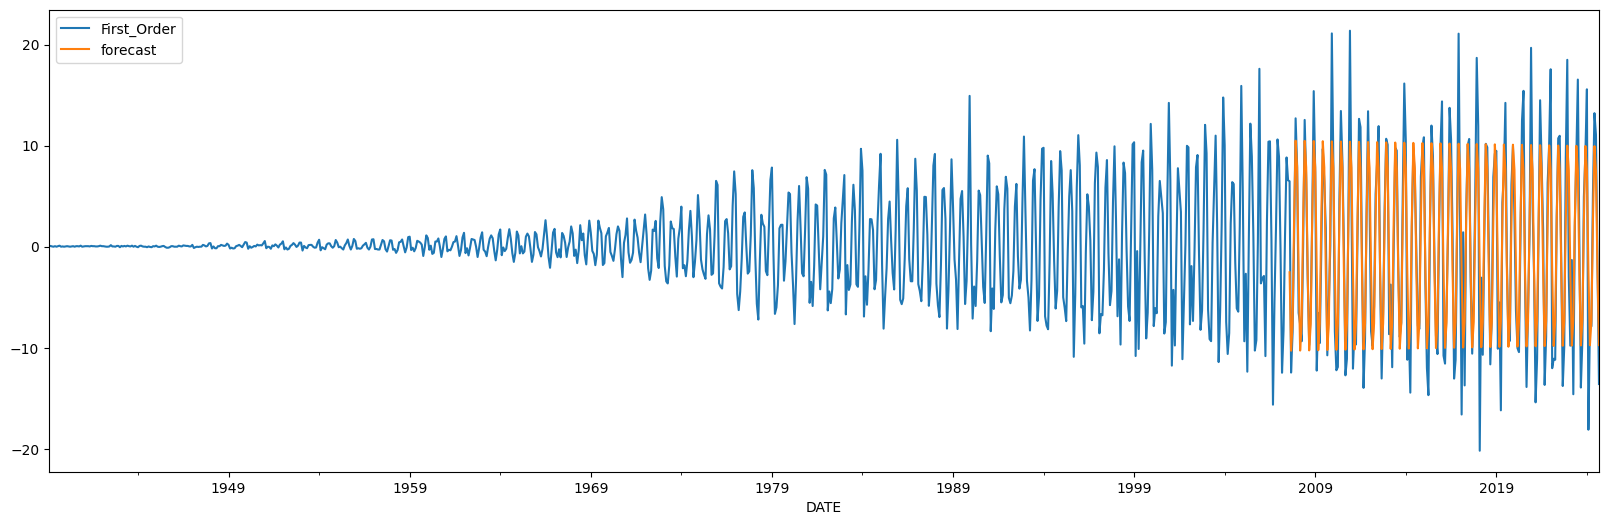

In [53]:
df[['First_Order','forecast']].plot(figsize=(20,6))

**It is only shoing the Orange portion of the data cause test set is on 2008 to 2019.**

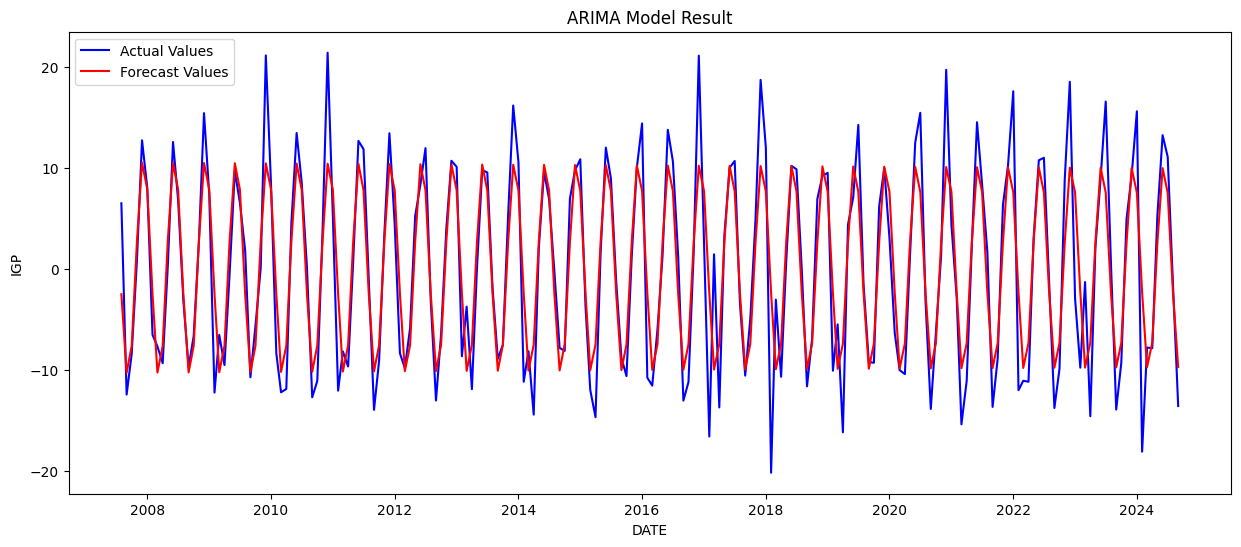

In [54]:
plt.figure(figsize=(15,6))

plt.plot(df['First_Order'][822:], color='blue', label='Actual Values')
plt.plot(df['forecast'][822:], color='red', label='Forecast Values')

plt.title('ARIMA Model Result')
plt.xlabel("DATE")
plt.ylabel("IGP")
plt.legend()

plt.show()

# 9. Conclusion

#### 1) As you can see the forcasted values are normal but the actual values are a little bit of extreme here.

#### 2) Forecasting values are overlapping of actual values, which means the prediction is good.

#### 3) Prediction is Perfect.

-----------

# 10. Evaluation Metrics

In [55]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

### a) Mean Absolute Error

In [57]:
mae= mean_absolute_error(df['First_Order'][822:], df['forecast'][822:])

mae

3.31400827887737

### b) Root Mean Squared Error

In [58]:
rmse= np.sqrt(mean_squared_error(df['First_Order'][822:], df['forecast'][822:]))

rmse

4.534741029628449